In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

   Feature  Coefficient   Intercept  R^2 Score          RMSE
0       Pr     0.449604   -1.974622   0.049396  9.749892e-01
1       La    -0.429515    3.917781   0.168700  9.117564e-01
2       Gd     0.856426   -3.858711   0.493934  7.113830e-01
3       Nd    -0.472230    3.992953   0.154325  9.196057e-01
4       Ce     0.198053    0.042707   0.013030  9.934638e-01
5       Sm    -0.321301    2.994513   0.054099  9.725744e-01
6        Y     0.258194   -0.604952   0.034998  9.823450e-01
7       EN     0.286386   -0.410173   0.059053  9.700244e-01
8        R    -0.714125    5.618304   0.303354  8.346532e-01
9       IE     1.628564   -9.069698   0.801748  4.452546e-01
10     LAS     0.309509   -0.801823   0.028698  9.855464e-01
11       M     0.009812    1.074588   0.000066  9.999672e-01
12       E    -0.350766    3.244052   0.097823  9.498302e-01
13       V     0.959991    0.045171   0.921583  2.800295e-01
14     CoO     0.602424    0.448872   0.362915  7.981762e-01
15     BaO     0.965461 

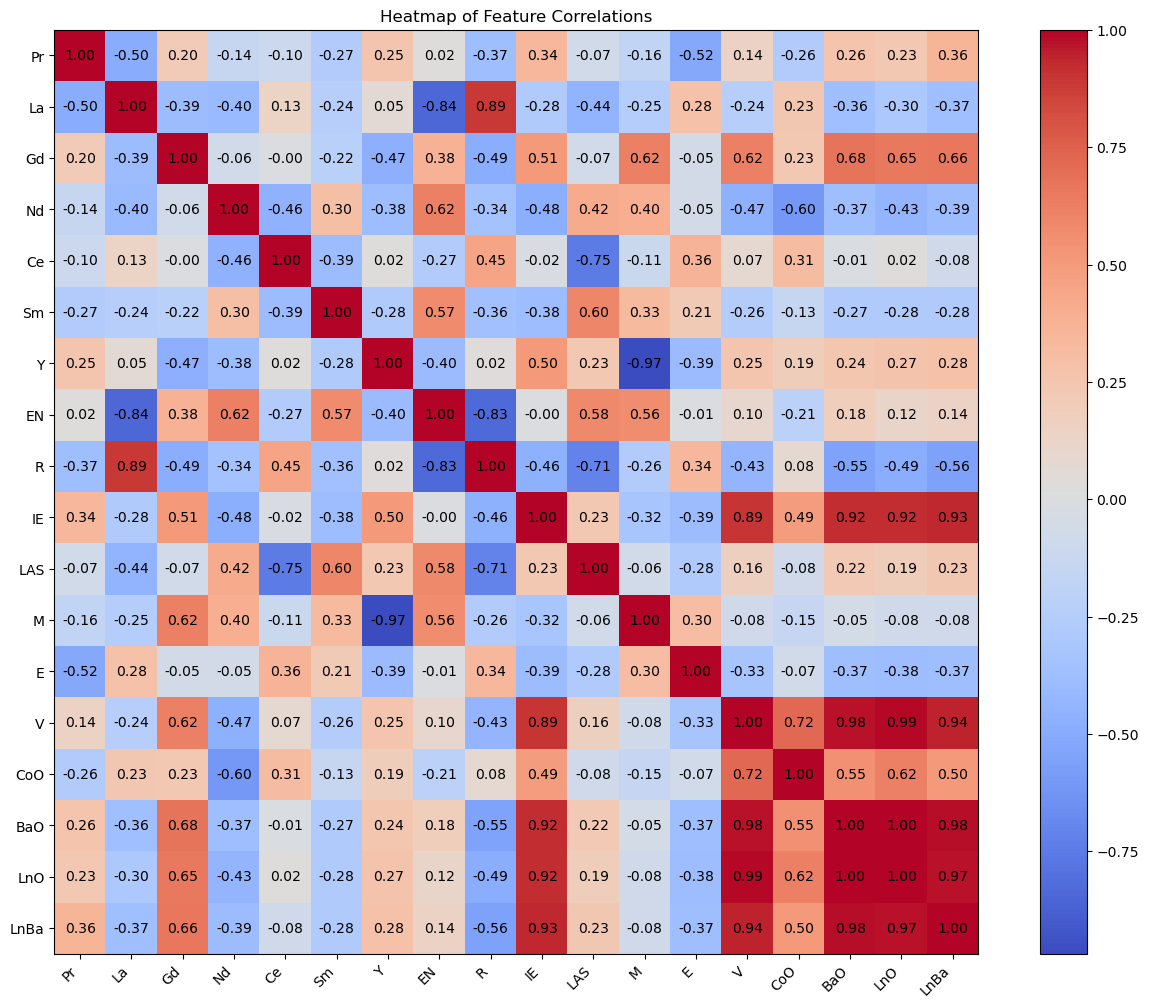

In [2]:
# Load data from Excel
data = pd.read_excel("./decline_rate_all.xlsx",sheet_name=0)

# Use the second column as X and the first as Y
X = data.iloc[:, 1:-1].values
Y = data.iloc[:, -1].values.reshape(-1, 1)

# Initialize an empty list to store results
results = []

# Loop through each feature (column) in X
for i in range(X.shape[1]):
    # Extract the i-th feature (reshape to 2D for sklearn)
    X_i = X[:, i].reshape(-1, 1)
    
    # Initialize and fit the Linear Regression model
    model = LinearRegression()
    model.fit(X_i, Y)
    
    # Predict Y using the fitted model
    Y_pred = model.predict(X_i)
    
    # Calculate R^2 score
    r2 = r2_score(Y, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    # Store results
    results.append({
        'Feature': data.columns.values[i+1],
        'Coefficient': model.coef_[0][0],
        'Intercept': model.intercept_[0],
        'R^2 Score': r2,
        'RMSE': rmse,
    })

model = LinearRegression()
model.fit(X, Y)
# Predict Y using the fitted model
Y_pred = model.predict(X)

# Calculate R^2 score
r2 = r2_score(Y, Y_pred)
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
# Store results
results.append({
    'Feature': "all",
    'Coefficient': model.coef_[0][0],
    'Intercept': model.intercept_[0],
    'R^2 Score': r2,
    'RMSE': rmse,
})

# Display results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("correlation.csv")

# Convert X to a DataFrame for correlation calculation
df_X = pd.DataFrame(X, columns=data.columns.values[1:-1])

# Calculate the correlation matrix
correlation_matrix = df_X.corr()

# Plotting the heatmap
plt.figure(figsize=(16, 12))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Heatmap of Feature Correlations')

# Adding text annotations for the correlation values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
correlation_matrix.to_csv('./feature_correlations.csv', index=True)

plt.show()

In [3]:
from sklearn.feature_selection import RFE
# Re-initialize the results DataFrame using pandas.concat
rfe_results = pd.DataFrame(columns=['Number of Features', 'Selected Features', 'R2', "RMSE"])

# Loop through the number of features from 1 to all features in X
for n_features_to_select in range(1, X.shape[1] + 1):
    # Initialize RFE with the linear regression model
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features_to_select)
    rfe.fit(X, Y.ravel())  # Fit the RFE model
    
    # Get the selected features
    selected_features = [data.columns.values[i+1] for i in range(X.shape[1]) if rfe.support_[i]]
    
    # Calculate the model score (R^2 score on the training data)
    Y_pred = rfe.predict(X)
    r2 = r2_score(Y, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    # Append the results to the DataFrame
    rfe_results = pd.concat([
        rfe_results,
        pd.DataFrame({
            'Number of Features': [n_features_to_select],
            'Selected Features': [', '.join(selected_features)],
            "Cor": [rfe.estimator_.coef_],
            'R2': [r2],
            "RMSE": [rmse]
        })
    ], ignore_index=True)

print(rfe_results)
rfe_results.to_csv("RFE.csv")

   Number of Features                                  Selected Features  \
0                   1                                                 IE   
1                   2                                            IE, LAS   
2                   3                                        Sm, IE, LAS   
3                   4                                    Nd, Sm, IE, LAS   
4                   5                                Nd, Sm, EN, IE, LAS   
5                   6                            Gd, Nd, Sm, EN, IE, LAS   
6                   7                         Gd, Nd, Sm, EN, R, IE, LAS   
7                   8                     La, Gd, Nd, Sm, EN, R, IE, LAS   
8                   9                 Pr, La, Gd, Nd, Sm, EN, R, IE, LAS   
9                  10              Pr, La, Gd, Nd, Sm, EN, R, IE, LAS, M   
10                 11           Pr, La, Gd, Nd, Sm, Y, EN, R, IE, LAS, M   
11                 12        Pr, La, Gd, Nd, Sm, Y, EN, R, IE, LAS, M, V   
12          

C:\Users\Tobby\AppData\Local\Temp\ipykernel_20684\4081582819.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rfe_results = pd.concat([


In [4]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Initialize the linear regression model
model = LinearRegression()

# Prepare a DataFrame to store the results with an initial set of columns
best_combinations_results = pd.DataFrame(columns=['Number of Features', 'R2', "RMSE"])

# Assuming 'data' is the DataFrame that contains your feature names and the dataset
feature_names = data.columns.values[1:]  # Adjust as necessary to correctly reference your feature names

# Add columns for each feature to store the importances
for feature in feature_names:
    best_combinations_results[feature] = 0

# Loop through the number of features from 1 to all features in X
for n_features_to_select in range(1, X.shape[1] + 1):
    feature_indices = range(X.shape[1])
    feature_combinations = list(combinations(feature_indices, n_features_to_select))
    print("%s features with %s combinations" % (n_features_to_select, len(feature_combinations)))
    best_rmse = float('inf')
    best_r2 = -float('inf')
    best_combination = None
    best_importances = None
    
    # Loop through each combination of features
    for combination in feature_combinations:
        # Select the features for this combination
        X_combination = X[:, combination]
        
        # Fit the linear regression model
        model.fit(X_combination, Y.ravel())
        
        # Predict the target values using the fitted model
        Y_pred = model.predict(X_combination)
        
        # Calculate the RMSE and R^2 score
        r2 = r2_score(Y, Y_pred)
        rmse = np.sqrt(mean_squared_error(Y, Y_pred))
        
        # Calculate normalized feature importance
        importances = np.abs(model.coef_)
        normalized_importances = importances / np.sum(importances)
        feature_importance_map = {feature_names[i]: importance for i, importance in zip(combination, normalized_importances)}
        
        # Check if this is the best combination so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_r2 = r2
            best_combination = combination
            best_importances = feature_importance_map

    # Prepare a row for the DataFrame
    row = {'Number of Features': n_features_to_select, 'R2': best_r2, "RMSE": best_rmse}
    # Initialize all features' importances to 0
    for feature in feature_names:
        row[feature] = 0
    # Update with actual importances where available
    for feature, importance in best_importances.items():
        row[feature] = importance

    # Append the results to the DataFrame using pd.concat
    new_row_df = pd.DataFrame([row])
    best_combinations_results = pd.concat([best_combinations_results, new_row_df], ignore_index=True)

print(best_combinations_results)
best_combinations_results.to_csv("best_combinations.csv")


C:\Users\Tobby\AppData\Local\Temp\ipykernel_20684\2414702185.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_combinations_results = pd.concat([best_combinations_results, new_row_df], ignore_index=True)


1 features with 18 combinations
2 features with 153 combinations
3 features with 816 combinations
4 features with 3060 combinations
5 features with 8568 combinations
6 features with 18564 combinations
7 features with 31824 combinations
8 features with 43758 combinations
9 features with 48620 combinations
10 features with 43758 combinations
11 features with 31824 combinations
12 features with 18564 combinations
13 features with 8568 combinations
14 features with 3060 combinations
15 features with 816 combinations
16 features with 153 combinations
17 features with 18 combinations
18 features with 1 combinations
   Number of Features        R2          RMSE        Pr        La        Gd  \
0                   1  0.933219  2.584206e-01  0.000000  0.000000  0.000000   
1                   2  0.955671  2.105453e-01  0.000000  0.178739  0.000000   
2                   3  0.969612  1.743221e-01  0.000000  0.000000  0.000000   
3                   4  0.978145  1.478354e-01  0.000000  0.000000  